In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')
import seaborn as sns

**Generate data**

In [5]:
L63_data_path = '../data/L63-trajectories'
save_folder = '../data/bunching'
name = 'nn'
N = 20000
L0 = 0.4
L1 = 3.5
bunching_threshold = 0.05
n_sample = 500
beta = 4e-5
partition = [300, 0, 0]
train = np.load(f'{L63_data_path}/train.npy')[:, :N].astype(np.float64)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(np.float64)

x = torch.Tensor(train.T[:-1])
y = torch.Tensor(train.T[1:])

model = srnn.SurrogateModel_NN(3, 300, name=name, save_folder=save_folder)
maxs = []
mins = []
bunching = []
left_bunching = []
right_bunching = []
loss = []
tau_f = []

for i in range(n_sample):
    print(f'working on sample#{i}')
    model.load(i)
    # model.init_with_rf(L0, L1, beta, train, partition=partition)
    M, m, B, l, r = model.compute_bunching(L0, L1, train, bunching_threshold)
    maxs.append(M.mean())
    mins.append(m.mean())
    bunching.append(B.sum())
    left_bunching.append(l.sum())
    right_bunching.append(r.sum())
    # tau_f.append(model.compute_tau_f_(test[:100], 0.05, 0.02, 1/0.91)[1].mean())
    # loss.append(model.loss_fn(x, y, beta).item())
    # model.save(i)
    
np.save(f'{model.save_folder}/maxs.npy', maxs)
np.save(f'{model.save_folder}/mins.npy', mins)
np.save(f'{model.save_folder}/bunching.npy', bunching)
np.save(f'{model.save_folder}/left_bunching.npy', left_bunching)
np.save(f'{model.save_folder}/right_bunching.npy', right_bunching)
# np.save(f'{model.save_folder}/tau_f.npy', tau_f)
# np.save(f'{model.save_folder}/loss.npy', loss)
# model.write_config()

working on sample#0
working on sample#1
working on sample#2
working on sample#3
working on sample#4
working on sample#5
working on sample#6
working on sample#7
working on sample#8
working on sample#9
working on sample#10
working on sample#11
working on sample#12
working on sample#13
working on sample#14
working on sample#15
working on sample#16
working on sample#17
working on sample#18
working on sample#19
working on sample#20
working on sample#21
working on sample#22
working on sample#23
working on sample#24
working on sample#25
working on sample#26
working on sample#27
working on sample#28
working on sample#29
working on sample#30
working on sample#31
working on sample#32
working on sample#33
working on sample#34
working on sample#35
working on sample#36
working on sample#37
working on sample#38
working on sample#39
working on sample#40
working on sample#41
working on sample#42
working on sample#43
working on sample#44
working on sample#45
working on sample#46
working on sample#47
wo

In [3]:
def plot(color_array, label):
    fig = plt.figure(figsize=(11, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    tau_f = np.load(f'{model.save_folder}/tau_f.npy')
    loss = np.log(np.load(f'{model.save_folder}/loss.npy'))
    im1 = ax1.scatter(loss, tau_f, c=color_array, cmap='viridis')
    ax1.set_xlabel('log loss')
    ax1.set_ylabel(r'$\tau_f$')
    ax1.set_title('colored with ' + label)
    fig.colorbar(im1, ax=ax1, orientation='vertical')
    ax2.scatter(color_array, tau_f)
    ax2.set_xlabel(f'{label}')
    ax2.set_ylabel(r'$\tau_f$')
    plt.savefig(f'{model.save_folder}/tau_f_vs_{label}.png')


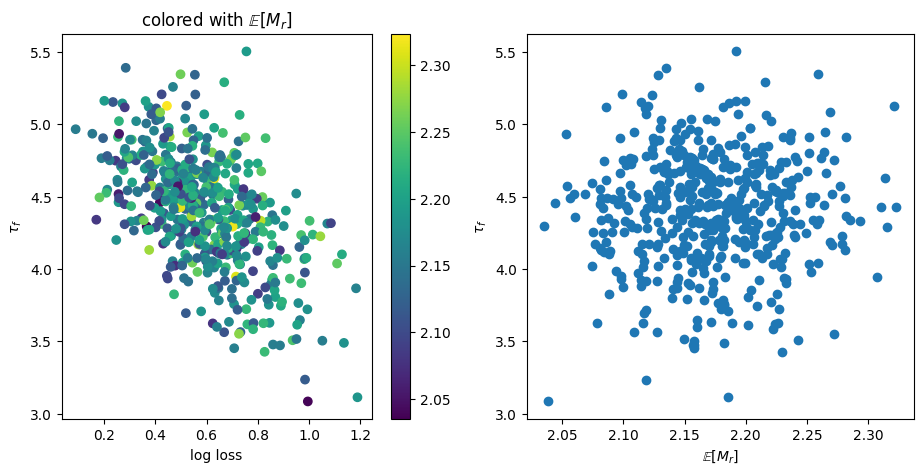

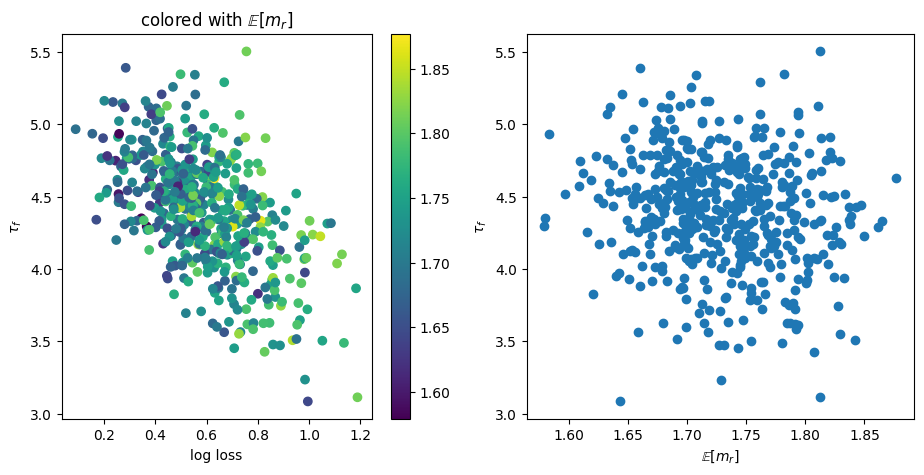

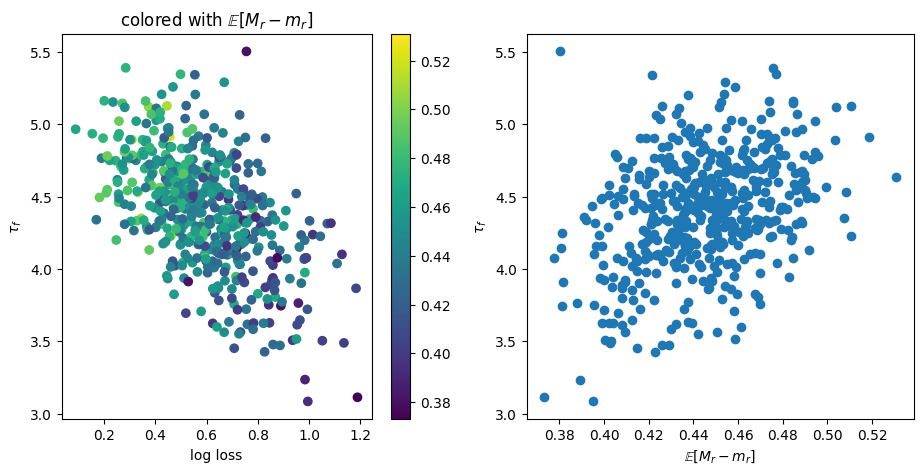

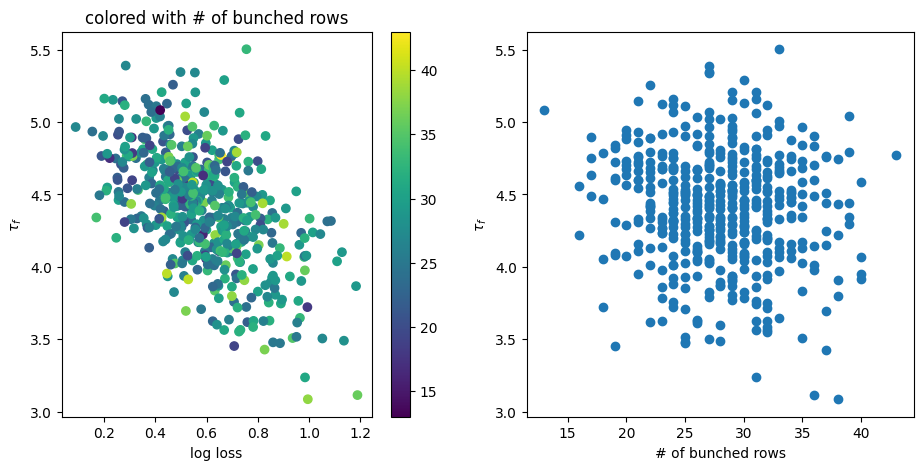

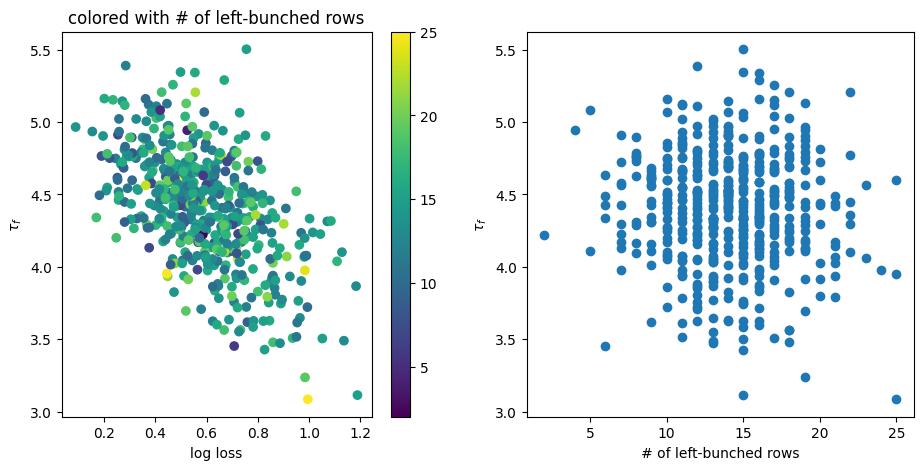

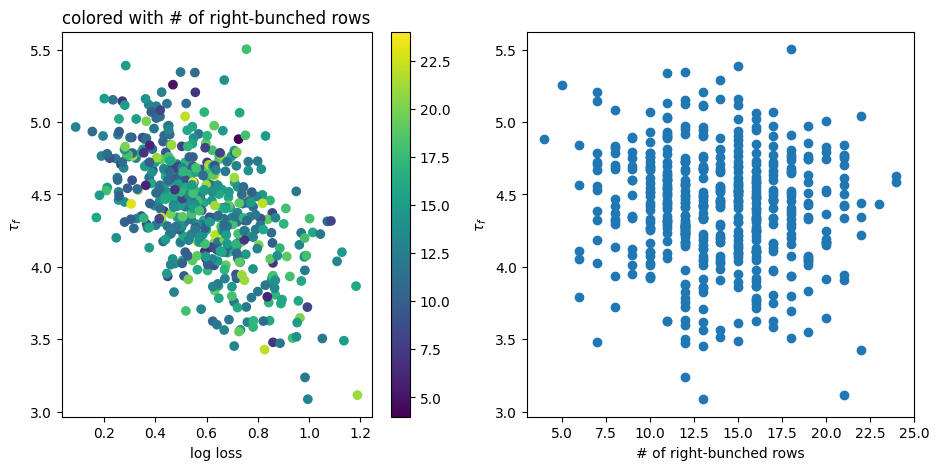

In [6]:
M_r = np.load(f'{model.save_folder}/maxs.npy')
m_r = np.load(f'{model.save_folder}/mins.npy')
B = np.load(f'{model.save_folder}/bunching.npy')
l = np.load(f'{model.save_folder}/left_bunching.npy')
r = np.load(f'{model.save_folder}/right_bunching.npy')
plot(M_r, r'$\mathbb{E}[M_r]$')
plot(m_r, r'$\mathbb{E}[m_r]$')
plot(M_r-m_r, r'$\mathbb{E}[M_r-m_r]$')
plot(B, '# of bunched rows')
plot(l, '# of left-bunched rows')
plot(r, '# of right-bunched rows')

In [143]:
def plot_extreme():
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)

    tau_f = np.load(f'{model.save_folder}/tau_f.npy')
    idx = np.arange(model.D_r)
    idx0, idx1 = np.argmin(tau_f), np.argmax(tau_f)
    model.load(idx0)
    M0, m0, B0 = model.compute_bunching(L0, L1, train, bunching_threshold)
    model.load(idx1)
    M1, m1, B1 = model.compute_bunching(L0, L1, train, bunching_threshold)
    
    
    # ax1.hist(M0, color='red', alpha=1.0, density=True, bins=100)#, label=fr'worst $\tau_f$={tau_f[idx0]:.2f}={tau_f[idx0]}')
    # ax1.hist(M1, color='blue', alpha=0.3, density=True, bins=100)#, label=fr'best $\tau_f$={tau_f[idx1]:.2f}={tau_f[idx1]}')
    sns.distplot(M1, hist=False, kde_kws={'clip': (L0, L1)}, ax=ax1, label=fr'best $\tau_f$={tau_f[idx1]:.2f}, $\mu$={np.mean(M1):.2f}, $\sigma$={np.std(M1):.2f}')
    sns.distplot(M0, hist=False, kde_kws={'clip': (L0, L1)}, ax=ax1, label=fr'worst $\tau_f$={tau_f[idx0]:.2f}, $\mu$={np.mean(M0):.2f}, $\sigma$={np.std(M0):.2f}')
    
    ax1.set_title(r'Density of $M_r$')
    ax1.legend()
  
    sns.distplot(m1, hist=False, kde_kws={'clip': (L0, L1)}, ax=ax2, label=fr'best $\tau_f$={tau_f[idx1]:.2f}, $\mu$={np.mean(m1):.2f}, $\sigma$={np.std(m1):.2f}')
    sns.distplot(m0, hist=False, kde_kws={'clip': (L0, L1)}, ax=ax2, label=fr'worst $\tau_f$={tau_f[idx0]:.2f}, $\mu$={np.mean(m0):.2f}, $\sigma$={np.std(m0):.2f}')
    
    ax2.set_title(r'Density of $m_r$')
    ax2.legend()

    sns.distplot(M1-m1, hist=False, kde_kws={'clip': (0., L1-L0)}, ax=ax3, label=fr'best $\tau_f$={tau_f[idx1]:.2f}, $\mu$={np.mean(M1-m1):.2f}, $\sigma$={np.std(M1-m1):.2f}')
    sns.distplot(M0-m0, hist=False, kde_kws={'clip': (0., L1-L0)}, ax=ax3, label=fr'worst $\tau_f$={tau_f[idx0]:.2f}, $\mu$={np.mean(M0-m0):.2f}, $\sigma$={np.std(M0-m0):.2f}')
    
    ax3.set_title(r'Density of $M_r-m_r$')
    ax3.legend()


    sns.distplot(M1-L0, hist=False, kde_kws={'clip': (0., L1-L0)}, ax=ax4, label=fr'best $\tau_f$={tau_f[idx1]:.2f}, $\mu$={np.mean(M1-L0):.2f}, $\sigma$={np.std(M1-L0):.2f}')
    sns.distplot(M0-L0, hist=False, kde_kws={'clip': (0., L1-L0)}, ax=ax4, label=fr'worst $\tau_f$={tau_f[idx0]:.2f}, $\mu$={np.mean(M0-L0):.2f}, $\sigma$={np.std(M0-L0):.2f}')

    ax4.set_title(r'Density of $M_r-m$ (left bunching)')
    ax4.legend()


    sns.distplot(L1-m1, hist=False, kde_kws={'clip': (0., L1-L0)}, ax=ax5, label=fr'best $\tau_f$={tau_f[idx1]:.2f}, $\mu$={np.mean(L1-m1):.2f}, $\sigma$={np.std(L1-m1):.2f}')
    sns.distplot(L1-m0, hist=False, kde_kws={'clip': (0., L1-L0)}, ax=ax5, label=fr'worst $\tau_f$={tau_f[idx0]:.2f}, $\mu$={np.mean(L1-m0):.2f}, $\sigma$={np.std(L1-m0):.2f}')

    ax5.set_title(r'Density of $M-m_r$ (right bunching)')
    ax5.legend()

    ax6.set_title('0-> #nonbunched rows, 1->#bunched rows')
    ax6.hist(B1.astype(float), label=fr'best $\tau_f$={tau_f[idx1]:.2f}')
    ax6.hist(B0.astype(float), label=fr'worst $\tau_f$={tau_f[idx0]:.2f}', alpha=0.5)
    ax6.legend()
    
    plt.savefig(f'{model.save_folder}/distribution_of_limits.png')
    return m0, M0, m1, M1

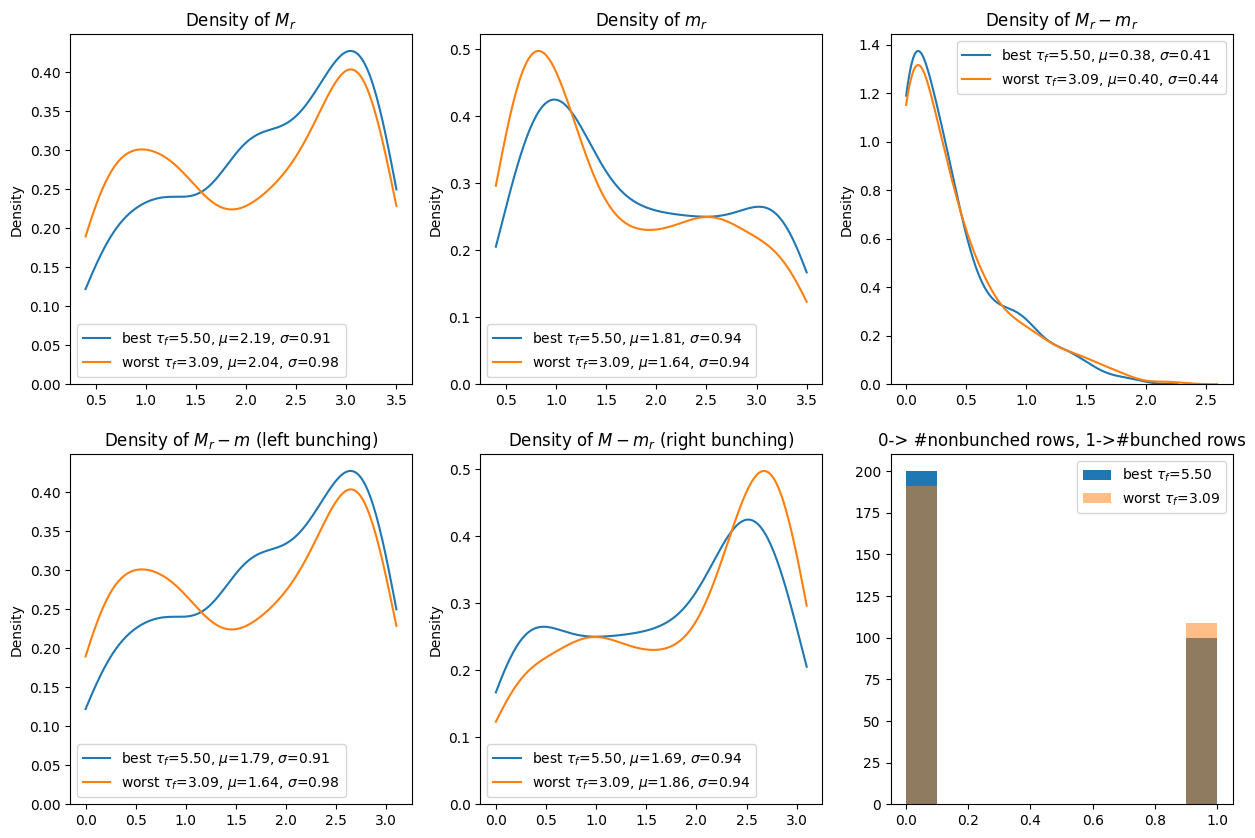

In [147]:
m0, M0, m1, M1 = plot_extreme()

In [56]:
model.init_with_rf(L0, L1, beta, train, partition=partition)
M, m, B = model.compute_bunching(L0, L1, train, bunching_threshold)

(array([20., 23., 26., 17., 23., 35., 31., 33., 42., 50.]),
 array([0.40543332, 0.71370048, 1.02196763, 1.33023478, 1.63850193,
        1.94676909, 2.25503624, 2.56330339, 2.87157054, 3.1798377 ,
        3.48810485]),
 <BarContainer object of 10 artists>)

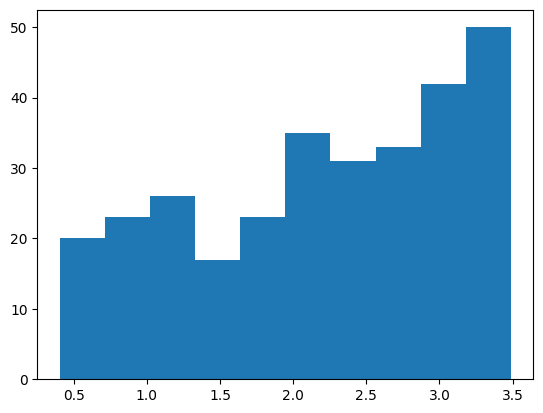

In [65]:
plt.hist(M)